## Sources
* Patwa et al. 
* AG Textbook
* https://github.com/Rodin-Sh/FakeNewsDetectionModel/blob/main/FakeNewsDetectionAlgorithm.ipynb
* https://towardsdatascience.com/predicting-fake-news-using-nlp-and-machine-learning-scikit-learn-glove-keras-lstm-7bbd557c3443 

## Wishlist
*   plot bias-variance trade-off for each baseline model (Model Complexity vs. Error, see Lecture #6 slides)



# Setup

In [37]:
# REMOVE UNNECESSARY DEPENDENCIES BEFORE FINAL REPORT

# import dependencies
import pandas as pd
import numpy as np
import nltk
import re
import itertools
import matplotlib.pyplot as plt

## nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag

## sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree

## joblib
from joblib import dump, load

# set seed
np.random.seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
# load data 
train = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/Constraint_Train.csv', header=0)
val = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/Constraint_Val.csv', header=0)

# REMOVE 'ID' FEATURE FROM DATASET? IS THE ML ALGORITHM BEING TRAINED ON THE 'ID'? IF SO, THIS IS USELESS NOISE THAT SHOULD BE REMOVED...
# SHOULD WE RELABEL THE 'TWEET' TO SOMETHING THAT MORE ACCURATELY REPRESENTS THE DATA, FOR EXAMPLE 'CLAIM' OR 'STATEMENT'? 'TWEET' MAY BE MISLEADING SINCE OUR DATA ISN'T ONLY COMPRISED OF TWEETS

In [39]:
print(len(train))
train.head()

6420


,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


# Pre-processing

In [40]:
# CONVERT "REAL" AND "FAKE" LABELS TO 0 AND 1 TO MAKE THEM MACHINE READABLE
# word_tokens = word_tokenize()
# ps = PorterStemmer() # creating an instance of PorterStemmer class

stop_words = set(stopwords.words("english")) # create list of stop words
def cleantext(string):
    text = string.lower().split() # convert letters to lowercase and split claims ('tweets') into separate words
    text = " ".join(text) # ???
    text = re.sub(r"http(\S)+",' ',text)    
    text = re.sub(r"www(\S)+",' ',text)
    text = re.sub(r"&",' and ',text) # replace '&' with ' and '
    text = text.replace('&amp',' ') # replace '&amp' with empty space
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text) # replace non-letters, non-numbers, & punctuation with empty space
    text = text.split() # ??? 
    #text = [ps.stem(word) for word in text] # set text equal to stemmed words
    text = [w for w in text if not w in stop_words] # remove stop words 
    text = " ".join(text) # joining the seperated pieces of string into one string
    return text

# apply cleantext() function to all tweets 
train['tweet'] = train['tweet'].map(lambda x: cleantext(x))
val['tweet'] = val['tweet'].map(lambda x: cleantext(x))
#test['tweet'] = test['tweet'].map(lambda x: cleantext(x))

# Feature Extraction


## Bag-of-Words (BoW)

In [41]:
# count vectorizer
cv = CountVectorizer() # count term frequency

# fit and transform train data to count vectorizer
cv.fit(train['tweet'].values)
cv_train = cv.transform(train['tweet'].values)

# fit and transform validation data to counter vectorizer
cv_val = cv.transform(val['tweet'].values)

## TF-IDF

In [42]:
# TF-IDF
tfidf = TfidfTransformer()

# fit the CountVector to TF-IDF transformer
tfidf.fit(cv_train)
tfidf_train = tfidf.transform(cv_train)

# do the same for the validation set
tfidf.fit(cv_val)
tfidf_val = tfidf.transform(cv_val)

# Model Training

## #1 SVM

In [43]:
# SVM
svm_clf = LinearSVC() # classifier
fit = svm_clf.fit(tfidf_train,train['label']) # train model

# make predictions
svm_pred = svm_clf.predict(tfidf_val)

## #2 Logistic Regression

In [44]:
# Logistic Regression
lr_clf = LogisticRegression() # classifier
fit = lr_clf.fit(tfidf_train,train['label']) # train model

# make predictions
lr_pred = lr_clf.predict(tfidf_val)

## #3 Gradient Boosting

In [45]:
# Gradient Boosting 
gb_clf = GradientBoostingClassifier() # classifier
fit = gb_clf.fit(tfidf_train,train['label']) # train model

# make predictions
gb_pred = gb_clf.predict(tfidf_val)

## #4 Decision Tree

In [46]:
# Decision Tree Classifier
dt_clf = tree.DecisionTreeClassifier() # classifier
fit = dt_clf.fit(tfidf_train,train['label']) # train model

# make predictions
dt_pred = dt_clf.predict(tfidf_val)

# Evaluation

In [47]:
# define print_metrics() function to print results
def print_metrics(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

In [48]:
# define plot_confusion_matrix() function to display results
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.show()

[[ 963   57]
 [  80 1040]]
              precision    recall  f1-score   support

        fake       0.92      0.94      0.93      1020
        real       0.95      0.93      0.94      1120

    accuracy                           0.94      2140
   macro avg       0.94      0.94      0.94      2140
weighted avg       0.94      0.94      0.94      2140

Accuracy :  0.935981308411215
Precison :  0.9361483939370142
Recall :  0.935981308411215
F1 :  0.9359565193297956


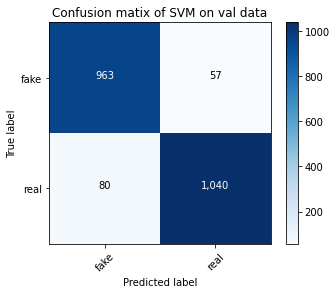

In [49]:
# SVM 
# display results
print_metrics(svm_pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],svm_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of SVM on val data')

[[ 957   63]
 [  95 1025]]
              precision    recall  f1-score   support

        fake       0.91      0.94      0.92      1020
        real       0.94      0.92      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140

Accuracy :  0.9261682242990654
Precison :  0.9265129977224534
Recall :  0.9261682242990654
F1 :  0.9261331076243714


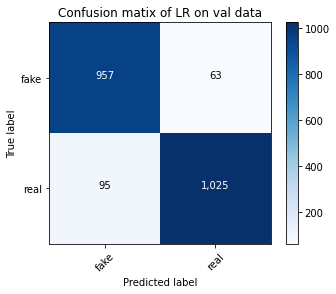

In [50]:
# Logistic Regression 
# display results
print_metrics(lr_pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],lr_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of LR on val data')

[[921  99]
 [179 941]]
              precision    recall  f1-score   support

        fake       0.84      0.90      0.87      1020
        real       0.90      0.84      0.87      1120

    accuracy                           0.87      2140
   macro avg       0.87      0.87      0.87      2140
weighted avg       0.87      0.87      0.87      2140

Accuracy :  0.8700934579439252
Precison :  0.8724397235529727
Recall :  0.8700934579439252
F1 :  0.8700480678174206


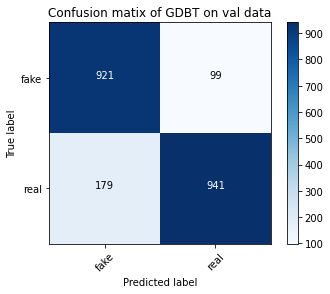

In [51]:
# Gradient Boosting 
# display results
print_metrics(gb_pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],gb_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of GDBT on val data')

[[837 183]
 [144 976]]
              precision    recall  f1-score   support

        fake       0.85      0.82      0.84      1020
        real       0.84      0.87      0.86      1120

    accuracy                           0.85      2140
   macro avg       0.85      0.85      0.85      2140
weighted avg       0.85      0.85      0.85      2140

Accuracy :  0.847196261682243
Precison :  0.8481227911725437
Recall :  0.847196261682243
F1 :  0.8473779060652775


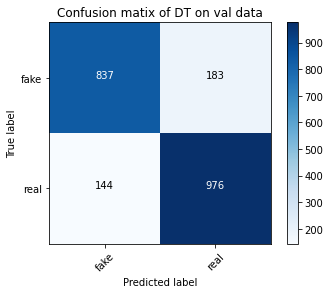

In [52]:
# Decision Tree
# display results
print_metrics(dt_pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],dt_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of DT on val data')

In [53]:
# create a df of misclassified posts
val_orig = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/Constraint_Val.csv', header=0)
svm_val_misclass_df = val_orig[svm_pred!=val['label']]

# inspect df
svm_val_misclass_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 1 to 2138
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      137 non-null    int64 
 1   tweet   137 non-null    object
 2   label   137 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.3+ KB


XGBoost
val:
[[942  78]
 [163 957]]
              precision    recall  f1-score   support

        fake       0.85      0.92      0.89      1020
        real       0.92      0.85      0.89      1120

    accuracy                           0.89      2140
   macro avg       0.89      0.89      0.89      2140
weighted avg       0.89      0.89      0.89      2140

Accuracy :  0.8873831775700934
Precison :  0.8901264185580775
Recall :  0.8873831775700934
F1 :  0.8873518225383265


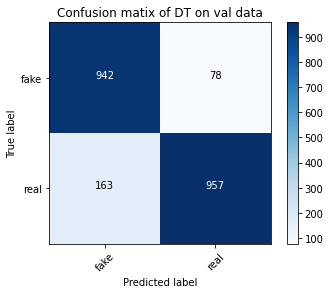

In [55]:
from xgboost import XGBClassifier
# XGBoost Classifier

# create pipeline
pipeline = Pipeline([
        ('bow', CountVectorizer(ngram_range=(1, 2))), # count term frequency
        ('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', XGBClassifier(max_depth=10, min_child_weight=3)) # classifier
    ])

fit = pipeline.fit(train['tweet'],train['label']) # train model
print('XGBoost')
print ('val:')
pred = pipeline.predict(val['tweet']) # make predictions

# display results
print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of DT on val data')